In [1]:
import numpy as np
from matplotlib import pyplot as plt

from nltk.corpus import brown, treebank, conll2000

import seaborn as sns

from gensim.models import KeyedVectors

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Embedding, Dense, TimeDistributed, LSTM, GRU, Bidirectional, SimpleRNN, RNN
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from conllu import parse

In [2]:
with open("./UD_English-Atis/en_atis-ud-train.conllu") as f:
    train_data = parse(f.read())
with open("./UD_English-Atis/en_atis-ud-dev.conllu") as f:
    dev_data = parse(f.read())
with open("./UD_English-Atis/en_atis-ud-test.conllu") as f:
    test_data = parse(f.read())

In [3]:
print(train_data[11][0], train_data[11][0]["upos"])

show VERB


In [4]:
def prepare_sentences(data):
    X = []
    y = []

    for sent in data:
        X_sentence = []
        y_sentence = []
        for word in sent:
            X_sentence.append(word["form"])
            y_sentence.append(word["upos"])

        X.append(X_sentence)
        y.append(y_sentence)

    return X, y

In [5]:
X_train, y_train = prepare_sentences(train_data)
X_dev, y_dev = prepare_sentences(dev_data)
X_test, y_test = prepare_sentences(test_data)

X_train = X_train+X_dev+X_test
y_train = y_train+y_dev+y_test

print(len(X_train), len(y_train))

5432 5432


In [6]:
num_words = len(set([word.lower() for sentence in X_train for word in sentence]))
num_tags   = len(set([word.lower() for sentence in y_train for word in sentence]))

In [7]:
print("Total number of tagged sentences: {}".format(len(X_train)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 5432
Vocabulary size: 932
Total number of tags: 14


In [8]:
print('sample X: ', X_train[0], '\n')
print('sample Y: ', y_train[0], '\n')

sample X:  ['what', 'is', 'the', 'cost', 'of', 'a', 'round', 'trip', 'flight', 'from', 'pittsburgh', 'to', 'atlanta', 'beginning', 'on', 'april', 'twenty', 'fifth', 'and', 'returning', 'on', 'may', 'sixth'] 

sample Y:  ['PRON', 'AUX', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'PROPN', 'ADP', 'PROPN', 'VERB', 'ADP', 'NOUN', 'NUM', 'ADJ', 'CCONJ', 'VERB', 'ADP', 'NOUN', 'ADJ'] 



In [9]:
print("Length of first input sequence  : {}".format(len(X_train[0])))
print("Length of first output sequence : {}".format(len(y_train[0])))

Length of first input sequence  : 23
Length of first output sequence : 23


In [10]:
word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X_train)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X_train)  # use the tokeniser to encode input sequence

In [11]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(y_train)
Y_encoded = tag_tokenizer.texts_to_sequences(y_train)

In [12]:
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X_train[0], '\n')
print('Y: ', y_train[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['what', 'is', 'the', 'cost', 'of', 'a', 'round', 'trip', 'flight', 'from', 'pittsburgh', 'to', 'atlanta', 'beginning', 'on', 'april', 'twenty', 'fifth', 'and', 'returning', 'on', 'may', 'sixth'] 

Y:  ['PRON', 'AUX', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'PROPN', 'ADP', 'PROPN', 'VERB', 'ADP', 'NOUN', 'NUM', 'ADJ', 'CCONJ', 'VERB', 'ADP', 'NOUN', 'ADJ'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [6, 19, 4, 145, 29, 13, 52, 47, 7, 2, 20, 1, 18, 652, 5, 188, 99, 240, 16, 311, 5, 171, 243] 

Y:  [6, 7, 5, 3, 2, 5, 3, 3, 3, 2, 1, 2, 1, 4, 2, 3, 9, 8, 10, 4, 2, 3, 8] 



In [13]:
different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


In [14]:
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 46


<AxesSubplot: >

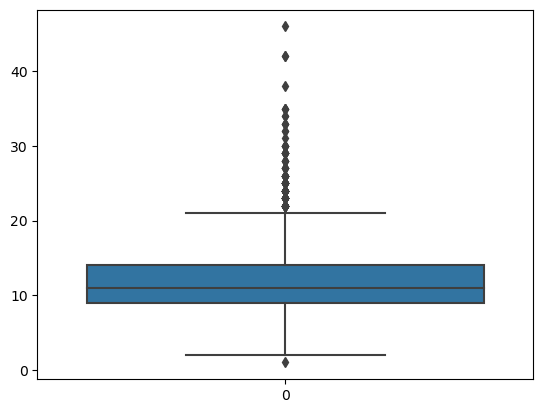

In [15]:
sns.boxplot(lengths)
# plt.show()

In [16]:
MAX_SEQ_LENGTH = 30  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [17]:
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[  0   0   0   0   0   0   0   6  19   4 145  29  13  52  47   7   2  20
   1  18 652   5 188  99 240  16 311   5 171 243] 



[ 0  0  0  0  0  0  0  6  7  5  3  2  5  3  3  3  2  1  2  1  4  2  3  9
  8 10  4  2  3  8]


In [18]:
X, Y = X_padded, Y_padded
print(len(X), len(Y))

5432 5432


In [19]:
path = './GoogleNews-vectors-negative300.bin'

word2vec= KeyedVectors.load_word2vec_format(path, binary=True)

In [20]:
word2vec

In [21]:
word2vec.most_similar(positive = ["King", "Woman"], negative = ["Man"])

[('Queen', 0.4929387867450714),
 ('Tupou_V.', 0.45174285769462585),
 ('Oprah_BFF_Gayle', 0.442213237285614),
 ('Jackson', 0.4402503967285156),
 ('NECN_Alison', 0.43312832713127136),
 ('Whitfield', 0.42834725975990295),
 ('Ida_Vandross', 0.42084527015686035),
 ('prosecutor_Dan_Satterberg', 0.420758992433548),
 ('martin_Luther_King', 0.42059651017189026),
 ('Coretta_King', 0.4202733635902405)]

In [22]:
EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index
print(word2id)

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

{'to': 1, 'from': 2, 'flights': 3, 'the': 4, 'on': 5, 'what': 6, 'flight': 7, 'me': 8, 'i': 9, 'san': 10, 'show': 11, 'boston': 12, 'a': 13, 'denver': 14, 'in': 15, 'and': 16, 'francisco': 17, 'atlanta': 18, 'is': 19, 'pittsburgh': 20, 'dallas': 21, 'all': 22, 'list': 23, 'baltimore': 24, 'philadelphia': 25, 'like': 26, 'are': 27, 'airlines': 28, 'of': 29, 'that': 30, 'between': 31, 'washington': 32, 'pm': 33, 'leaving': 34, 'please': 35, 'morning': 36, 'would': 37, 'fly': 38, 'city': 39, 'for': 40, 'wednesday': 41, 'first': 42, 'need': 43, 'fare': 44, 'after': 45, 'oakland': 46, 'trip': 47, 'there': 48, "'d": 49, 'ground': 50, 'cheapest': 51, 'round': 52, 'you': 53, 'transportation': 54, 'which': 55, 'does': 56, 'class': 57, 'arriving': 58, 'before': 59, 'milwaukee': 60, 'st.': 61, 'with': 62, 'afternoon': 63, 'available': 64, 'have': 65, 'american': 66, 'new': 67, 'one': 68, 'give': 69, 'dc': 70, 'at': 71, 'fares': 72, 'york': 73, 'leave': 74, 'monday': 75, 'way': 76, 'airport': 77, 

In [23]:
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (933, 300)


In [24]:
embedding_weights[word_tokenizer.word_index['what']]

array([ 0.13964844, -0.00616455,  0.21484375,  0.07275391, -0.16113281,
        0.07568359,  0.16796875, -0.20117188,  0.12597656,  0.00915527,
        0.05249023, -0.15136719, -0.02758789,  0.04199219, -0.234375  ,
        0.13867188, -0.02600098,  0.07910156,  0.02746582, -0.13085938,
       -0.02478027,  0.10009766, -0.07910156, -0.07714844,  0.03759766,
        0.16894531,  0.05371094, -0.05200195,  0.14453125, -0.04370117,
       -0.12597656,  0.06884766, -0.10595703, -0.14550781, -0.00331116,
        0.01367188,  0.13964844,  0.01660156,  0.03417969,  0.16113281,
       -0.01080322,  0.06689453,  0.06835938, -0.15136719, -0.16894531,
        0.03295898, -0.06884766,  0.06787109, -0.07373047,  0.08300781,
        0.05761719,  0.14550781, -0.11865234, -0.13671875,  0.12402344,
        0.04296875, -0.11962891, -0.08154297,  0.06494141, -0.05639648,
       -0.04394531,  0.1484375 , -0.07714844,  0.04614258, -0.02624512,
       -0.06591797,  0.04980469,  0.08886719, -0.01647949, -0.02

In [25]:
Y = to_categorical(Y)

In [26]:
print(Y.shape)

(5432, 30, 15)


In [27]:
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [28]:
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [29]:
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (3924, 30)
Shape of output sequences: (3924, 30, 15)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (693, 30)
Shape of output sequences: (693, 30, 15)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (815, 30)
Shape of output sequences: (815, 30, 15)


In [30]:
NUM_CLASSES = Y.shape[2]

In [31]:

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

2023-03-06 23:18:40.706069: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-06 23:18:40.707873: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [32]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [33]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           279900    
                                                                 
 simple_rnn (SimpleRNN)      (None, 30, 64)            23360     
                                                                 
 time_distributed (TimeDistr  (None, 30, 15)           975       
 ibuted)                                                         
                                                                 
Total params: 304,235
Trainable params: 304,235
Non-trainable params: 0
_________________________________________________________________


In [34]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10


2023-03-06 23:18:43.252156: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-06 23:18:43.773459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 1.3143 - acc: 0.7760

2023-03-06 23:19:00.355327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 17s 519ms/step - loss: 1.3143 - acc: 0.7760 - val_loss: 0.6078 - val_acc: 0.8594
Epoch 2/10
31/31 [==============================] - 15s 494ms/step - loss: 0.4194 - acc: 0.9102 - val_loss: 0.2827 - val_acc: 0.9478
Epoch 3/10
31/31 [==============================] - 15s 500ms/step - loss: 0.2011 - acc: 0.9657 - val_loss: 0.1496 - val_acc: 0.9754
Epoch 4/10
31/31 [==============================] - 15s 472ms/step - loss: 0.1099 - acc: 0.9824 - val_loss: 0.0939 - val_acc: 0.9826
Epoch 5/10
31/31 [==============================] - 15s 475ms/step - loss: 0.0711 - acc: 0.9872 - val_loss: 0.0686 - val_acc: 0.9853
Epoch 6/10
31/31 [==============================] - 14s 463ms/step - loss: 0.0526 - acc: 0.9891 - val_loss: 0.0556 - val_acc: 0.9865
Epoch 7/10
31/31 [==============================] - 15s 477ms/step - loss: 0.0424 - acc: 0.9899 - val_loss: 0.0480 - val_acc: 0.9877
Epoch 8/10
31/31 [==============================] - 15s 475ms/step - loss: 0.036

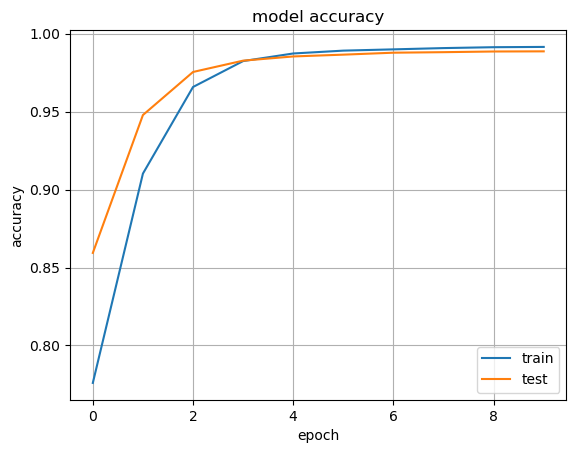

In [35]:
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [36]:
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

26/26 [==============================] - 1s 45ms/step - loss: 0.0319 - acc: 0.9912
Loss: 0.03185171261429787,
Accuracy: 0.9912065267562866


In [37]:
rnn_model.save("pos_rnn.h5")

In [38]:
sent = "Mary had a little lamb"

In [39]:
print(X_test)

[[  0   0   0 ... 373  42  57]
 [  0   0   0 ...   5  13 347]
 [  0   0   0 ... 149   1  96]
 ...
 [  0   0   0 ... 272  57  44]
 [  0   0   0 ...  25   1  21]
 [  0   0   0 ... 208  99 129]]


In [48]:
print(sent.lower().split())

word_tokenizer.word_index

t = word_tokenizer.texts_to_sequences([sent.lower().split()])

['mary', 'had', 'a', 'little', 'lamb']


In [50]:
sent_padded = pad_sequences(t, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
sent_padded

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 13]],
      dtype=int32)